In [5]:
"""
Cleaned and refactored pipeline for:
- reading flight logs (whitespace-separated),
- converting lat/lon/alt -> Cartesian,
- computing distance, transmission rate, latency,
- selecting optimal paths for two ground stations (Heathrow, Newark),
- finding two nearest relay flights (based on rate & latency),
- saving results to Excel.
"""

import math
import random
from typing import List, Tuple, Dict
import pandas as pd
import numpy as np

# ---------- Configuration ----------
INPUT_FILE = "NA_11_Jun_29_2018_UTC11 (1).CSV"  # change if needed
OUTPUT_XLSX = "optimal_paths.xlsx"
EARTH_RADIUS_M = 6_371_000.0

# Ground stations
GROUND_STATIONS = {
    "Heathrow": {"lat": 51.4700, "lon": -0.4543, "alt": 81.73},
    "Newark":   {"lat": 40.6895, "lon": -74.1745, "alt": 8.72}
}

# Transmission rate model options:
#   "random" -> random.uniform(0, 100) with optional seed
#   "distance_model" -> deterministic decreasing function of distance
TRANSMISSION_MODEL = "distance_model"
RANDOM_SEED = 123  # only used when TRANSMISSION_MODEL == "random"

# ---------- Utilities ----------
def convert_to_cartesian(lat_deg: float, lon_deg: float, alt_m: float) -> Tuple[float, float, float]:
    """
    Convert geographic coordinates (lat, lon in degrees) and altitude (m)
    to Earth-centered Cartesian coordinates (x, y, z) in meters.
    """
    lat = math.radians(lat_deg)
    lon = math.radians(lon_deg)
    r = EARTH_RADIUS_M + alt_m
    x = r * math.cos(lat) * math.cos(lon)
    y = r * math.cos(lat) * math.sin(lon)
    z = r * math.sin(lat)
    return x, y, z

def euclidean_distance_3d(a: Tuple[float, float, float], b: Tuple[float, float, float]) -> float:
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2)

def transmission_rate_from_distance(distance_m: float) -> float:
    """
    Deterministic model: rate (Mbps) decreases with distance.
    Adjust parameters below as desired.
    """
    # Parameters for the simple distance-based model
    max_rate = 100.0         # Mbps at zero distance (theoretical max)
    rolloff_k = 0.02         # Mbps reduction per kilometer (tuneable)
    distance_km = distance_m / 1000.0
    rate = max_rate - (rolloff_k * distance_km)
    return max(0.0, rate)

def random_transmission_rate(distance_m: float) -> float:
    return random.uniform(0, 100)

def calculate_latency_seconds(distance_m: float) -> float:
    c = 299_792_458.0  # speed of light, m/s
    return distance_m / c

# ---------- IO & Parsing ----------
def load_flight_dataframe(filename: str) -> pd.DataFrame:
    """
    Loads a whitespace-separated CSV like:
    FlightNo Timestamp Altitude Latitude Longitude
    Handles files with or without header robustly.
    Returns DataFrame with columns: ['flight_no','timestamp','altitude','latitude','longitude']
    """
    # Try reading with delim_whitespace; if header present, pandas will parse into 5 columns.
    df = pd.read_csv(filename, delim_whitespace=True, header=None, dtype=str, engine="python")
    # Some files may include an index or extra empty lines; drop rows with all NaN or incorrect length
    df = df.dropna(how="all")
    if df.shape[1] < 5:
        raise ValueError("Expected at least 5 whitespace-separated columns per row.")
    # Keep first five columns
    df = df.iloc[:, :5]
    df.columns = ['flight_no', 'timestamp', 'altitude', 'latitude', 'longitude']
    # Convert numeric columns
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    df['altitude'] = pd.to_numeric(df['altitude'], errors='coerce')
    df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
    df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
    # Drop rows with missing numeric data
    df = df.dropna(subset=['timestamp','altitude','latitude','longitude']).reset_index(drop=True)
    return df

# ---------- Core Processing ----------
def build_cartesian_records(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes the parsed df and returns a new DataFrame with columns:
    ['flight_no','timestamp','altitude','latitude','longitude','x','y','z']
    """
    xs, ys, zs = [], [], []
    for _, row in df.iterrows():
        x,y,z = convert_to_cartesian(row['latitude'], row['longitude'], row['altitude'])
        xs.append(x); ys.append(y); zs.append(z)
    df2 = df.copy()
    df2['x'] = xs; df2['y'] = ys; df2['z'] = zs
    return df2

def score_link(distance_m: float, model: str = TRANSMISSION_MODEL) -> Tuple[float, float]:
    """
    Returns (transmission_rate_Mbps, latency_s) for a given distance.
    """
    if model == "random":
        rate = random_transmission_rate(distance_m)
    else:
        rate = transmission_rate_from_distance(distance_m)
    latency = calculate_latency_seconds(distance_m)
    return rate, latency

def find_optimal_paths_for_groundstation(records: pd.DataFrame, gs_lat: float, gs_lon: float, gs_alt: float,
                                          model: str = TRANSMISSION_MODEL) -> Dict[str, Tuple[float, float, float]]:
    """
    For each flight (grouped by flight_no), finds the timestamp entry with:
        - maximum transmission rate; if ties, choose smaller latency.
    Returns a dict:
      flight_no -> (best_timestamp, best_rate_Mbps, best_latency_s)
    """
    results = {}
    # precompute ground station cartesian
    gs_xyz = convert_to_cartesian(gs_lat, gs_lon, gs_alt)
    for flight_no, group in records.groupby('flight_no'):
        best = None  # tuple (timestamp, rate, latency)
        for _, row in group.iterrows():
            aircraft_xyz = (row['x'], row['y'], row['z'])
            dist = euclidean_distance_3d(aircraft_xyz, gs_xyz)
            rate, latency = score_link(dist, model)
            ts = row['timestamp']
            if best is None or (rate > best[1]) or (math.isclose(rate, best[1]) and latency < best[2]):
                best = (ts, rate, latency)
        if best is not None:
            results[flight_no] = best
    return results

# ---------- Relay Finder ----------
def find_two_nearest_relays(flight_metrics_src: Dict[str, Tuple[float,float,float]],
                            flight_metrics_dst: Dict[str, Tuple[float,float,float]]) -> Dict[str, Tuple[Tuple[str,float], Tuple[str,float]]]:
    """
    For each flight in flight_metrics_src, find two flights in flight_metrics_dst that are
    nearest in the 2D metric space (normalized transmission_rate, latency).
    Returns mapping:
        src_flight -> ((relay1, score1), (relay2, score2))
    where score is Euclidean distance in normalized metric space.
    """
    # Build df for dst metrics
    dst_rows = []
    for fn, (ts, rate, lat) in flight_metrics_dst.items():
        dst_rows.append({'flight_no': fn, 'rate': rate, 'lat': lat})
    dst_df = pd.DataFrame(dst_rows)
    if dst_df.empty:
        return {}
    # Normalize columns to zero-mean unit-std to make rate & latency comparable
    norm_rate = (dst_df['rate'] - dst_df['rate'].mean()) / (dst_df['rate'].std() + 1e-9)
    norm_lat = (dst_df['lat'] - dst_df['lat'].mean()) / (dst_df['lat'].std() + 1e-9)
    dst_df['nr'] = norm_rate
    dst_df['nl'] = norm_lat
    dst_df = dst_df.set_index('flight_no')

    relays = {}
    for src_fn, (ts_s, rate_s, lat_s) in flight_metrics_src.items():
        # normalize src metrics using dst mean/std (consistent basis)
        nr_s = (rate_s - dst_df['rate'].mean()) / (dst_df['rate'].std() + 1e-9)
        nl_s = (lat_s - dst_df['lat'].mean()) / (dst_df['lat'].std() + 1e-9)
        # compute distances
        distances = np.sqrt((dst_df['nr'] - nr_s)**2 + (dst_df['nl'] - nl_s)**2)
        distances = distances.sort_values()
        nearest = distances.head(2)
        relay_info = tuple((rn, float(distances.loc[rn])) for rn in nearest.index)
        # if only one or zero relays available, fill accordingly
        if len(relay_info) == 1:
            relay_info = (relay_info[0], (None, None))
        elif len(relay_info) == 0:
            relay_info = ((None, None), (None, None))
        relays[src_fn] = relay_info
    return relays

# ---------- Save results ----------
def save_optimal_paths_to_excel(heathrow_metrics: Dict, newark_metrics: Dict, filename: str = OUTPUT_XLSX):
    # Convert dicts to DataFrame for nicer Excel output
    def dict_to_df(metrics: Dict[str, Tuple[float,float,float]]):
        rows = []
        for fn, (ts, rate, lat) in metrics.items():
            rows.append({'Flight No.': fn, 'Timestamp': ts, 'Transmission Rate (Mbps)': rate, 'Latency (s)': lat})
        return pd.DataFrame(rows).sort_values('Flight No.')
    hdf = dict_to_df(heathrow_metrics)
    ndf = dict_to_df(newark_metrics)
    with pd.ExcelWriter(filename, engine="openpyxl") as writer:
        hdf.to_excel(writer, sheet_name="Heathrow", index=False)
        ndf.to_excel(writer, sheet_name="Newark", index=False)
    print(f"Saved optimal paths to {filename}")

# ---------- Main flow ----------
def main():
    # seed randomness if using random model
    if TRANSMISSION_MODEL == "random":
        random.seed(RANDOM_SEED)

    print("Loading dataset...")
    df = load_flight_dataframe(INPUT_FILE)
    print(f"Loaded {len(df)} valid position records for {df['flight_no'].nunique()} unique flights.")

    print("Converting to Cartesian coordinates...")
    records = build_cartesian_records(df)

    print("Finding optimal paths to ground stations...")
    heathrow = GROUND_STATIONS['Heathrow']
    newark = GROUND_STATIONS['Newark']
    heathrow_metrics = find_optimal_paths_for_groundstation(records, heathrow['lat'], heathrow['lon'], heathrow['alt'])
    newark_metrics = find_optimal_paths_for_groundstation(records, newark['lat'], newark['lon'], newark['alt'])
    print(f"Heathrow optimal entries: {len(heathrow_metrics)}, Newark optimal entries: {len(newark_metrics)}")

    print("Saving optimal results to Excel...")
    save_optimal_paths_to_excel(heathrow_metrics, newark_metrics, OUTPUT_XLSX)

    print("Finding two nearest relay flights (Heathrow->Newark and Newark->Heathrow)...")
    relay_h_to_n = find_two_nearest_relays(heathrow_metrics, newark_metrics)
    relay_n_to_h = find_two_nearest_relays(newark_metrics, heathrow_metrics)

    # Print a concise summary:
    print("\nSample of optimal paths (Heathrow):")
    for i, (fn, vals) in enumerate(list(heathrow_metrics.items())[:10]):
        ts, rate, lat = vals
        relays = relay_h_to_n.get(fn, (("N/A", None), ("N/A", None)))
        print(f"Flight {fn}: ts={ts}, rate={rate:.3f} Mbps, latency={lat:.6f} s, relays={relays}")
        if i >= 9: break

    print("\nSample of optimal paths (Newark):")
    for i, (fn, vals) in enumerate(list(newark_metrics.items())[:10]):
        ts, rate, lat = vals
        relays = relay_n_to_h.get(fn, (("N/A", None), ("N/A", None)))
        print(f"Flight {fn}: ts={ts}, rate={rate:.3f} Mbps, latency={lat:.6f} s, relays={relays}")
        if i >= 9: break

    print("\nDone.")

if __name__ == "__main__":
    main()


Loading dataset...
Loaded 149 valid position records for 149 unique flights.
Converting to Cartesian coordinates...
Finding optimal paths to ground stations...
Heathrow optimal entries: 149, Newark optimal entries: 149
Saving optimal results to Excel...


/tmp/ipython-input-4258092900.py:79: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, delim_whitespace=True, header=None, dtype=str, engine="python")


Saved optimal paths to optimal_paths.xlsx
Finding two nearest relay flights (Heathrow->Newark and Newark->Heathrow)...

Sample of optimal paths (Heathrow):
Flight AA101: ts=1530270000.0, rate=80.272 Mbps, latency=0.003290 s, relays=(('BA212', 0.32502957762798956), ('LH475', 0.43995138435270387))
Flight AA151: ts=1530270000.0, rate=92.659 Mbps, latency=0.001224 s, relays=(('LH423', 0.03494069395820693), ('DL118', 0.04811670354352827))
Flight AA198: ts=1530270000.0, rate=0.000 Mbps, latency=0.017882 s, relays=(('BA49', 0.001030663253260733), ('BA179', 0.00125921477420321))
Flight AA204: ts=1530270000.0, rate=0.000 Mbps, latency=0.017901 s, relays=(('BA179', 0.002307066154633941), ('BA49', 0.004596944182097884))
Flight AA209: ts=1530270000.0, rate=58.728 Mbps, latency=0.006883 s, relays=(('DL270', 0.2972864208872573), ('UA123', 0.30575479519317855))
Flight AA221: ts=1530270000.0, rate=68.246 Mbps, latency=0.005296 s, relays=(('DL270', 0.745408067427744), ('UA123', 0.7538764417336653))
Fli

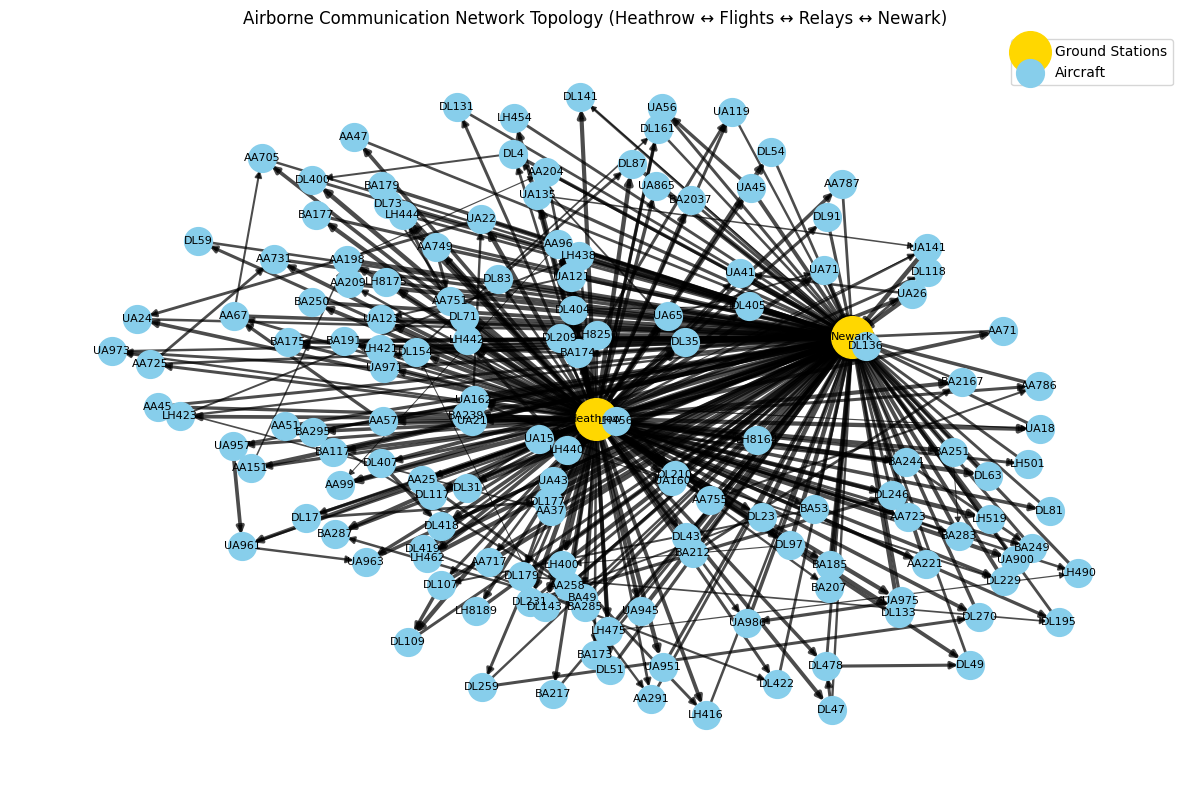

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# --- Load dataset ---
file_path = "NA_11_Jun_29_2018_UTC11 (1).CSV"
this_dataset = pd.read_csv(file_path, sep=None, engine='python')

# --- Create graph ---
G = nx.DiGraph()

# Ground stations
ground_stations = ["Heathrow", "Newark"]
G.add_nodes_from(ground_stations)

# Aircraft nodes (unique IDs from first column)
flight_nodes = this_dataset.iloc[:, 0].unique()
G.add_nodes_from(flight_nodes)

# Random assignment of Heathrow → Flight → Relay → Newark connections
np.random.seed(42)
for flight in flight_nodes:
    he_rate = np.random.uniform(50, 100)
    new_rate = np.random.uniform(50, 100)
    G.add_edge("Heathrow", flight, weight=he_rate)
    G.add_edge(flight, "Newark", weight=new_rate)

# Create relay links between flights (multi-hop)
flight_list = list(flight_nodes)
for i in range(0, len(flight_list) - 1):
    if np.random.rand() > 0.6:  # 60% chance of relay
        relay_rate = np.random.uniform(20, 80)
        G.add_edge(flight_list[i], flight_list[i + 1], weight=relay_rate)

# --- Layout ---
pos = nx.spring_layout(G, seed=42, k=1)

# --- Draw ---
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, nodelist=ground_stations, node_color="gold", node_size=900, label="Ground Stations")
nx.draw_networkx_nodes(G, pos, nodelist=flight_nodes, node_color="skyblue", node_size=400, label="Aircraft")

edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[d['weight']/30 for (u, v, d) in edges], alpha=0.7)

nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Airborne Communication Network Topology (Heathrow ↔ Flights ↔ Relays ↔ Newark)", fontsize=12)
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import math # Import math for coordinate conversion

# --- Utilities (copied from NY_Zz6JLTCBs) ---
def convert_to_cartesian(lat_deg: float, lon_deg: float, alt_m: float) -> tuple[float, float, float]:
    """
    Convert geographic coordinates (lat, lon in degrees) and altitude (m)
    to Earth-centered Cartesian coordinates (x, y, z) in meters.
    """
    EARTH_RADIUS_M = 6_371_000.0 # Define Earth radius
    lat = math.radians(lat_deg)
    lon = math.radians(lon_deg)
    r = EARTH_RADIUS_M + alt_m
    x = r * math.cos(lat) * math.cos(lon)
    y = r * math.cos(lat) * math.sin(lon)
    z = r * math.sin(lat)
    return x, y, z


# --- Load dataset ---
file_path = "NA_11_Jun_29_2018_UTC11 (1).CSV"
this_dataset = pd.read_csv(file_path, delim_whitespace=True, header=None)

# --- Assume columns represent ---
# 0 = Flight ID
# 1 = Timestamp
# 2 = Altitude
# 3 = Latitude
# 4 = Longitude
this_dataset.columns = ["Flight_ID", "Timestamp", "Altitude", "Latitude", "Longitude"]

# Convert numeric columns, coercing errors
this_dataset['Altitude'] = pd.to_numeric(this_dataset['Altitude'], errors='coerce')
this_dataset['Latitude'] = pd.to_numeric(this_dataset['Latitude'], errors='coerce')
this_dataset['Longitude'] = pd.to_numeric(this_dataset['Longitude'], errors='coerce')

# Drop rows with missing numeric data
this_dataset = this_dataset.dropna(subset=['Altitude', 'Latitude', 'Longitude']).reset_index(drop=True)


# --- Create directed graph ---
G = nx.DiGraph()

# Ground station coordinates (using approximate altitude)
ground_stations = {
    "Heathrow": {"Latitude": 51.4700, "Longitude": -0.4543, "Altitude": 81.73},
    "Newark": {"Latitude": 40.6895, "Longitude": -74.1745, "Altitude": 8.72}
}

# Add ground stations with 3D Cartesian positions
for name, coords in ground_stations.items():
    x, y, z = convert_to_cartesian(coords["Latitude"], coords["Longitude"], coords["Altitude"])
    G.add_node(name, pos=(x, y, z), color="red") # Changed color to red for ground stations

# --- Add aircraft nodes from dataset with 3D Cartesian positions ---
# Use the first valid position for each flight for a static topology visualization
flight_data_first_pos = this_dataset.groupby("Flight_ID").first().reset_index()

for _, row in flight_data_first_pos.iterrows():
    x, y, z = convert_to_cartesian(row["Latitude"], row["Longitude"], row["Altitude"])
    G.add_node(row["Flight_ID"], pos=(x, y, z), color="skyblue")

# --- Create edges ---
np.random.seed(42)
# Using flight_data_first_pos to iterate through unique flights
for _, row in flight_data_first_pos.iterrows():
    flight = row["Flight_ID"]
    # Heathrow → flight
    G.add_edge("Heathrow", flight, weight=np.random.uniform(50, 100))
    # flight → Newark
    G.add_edge(flight, "Newark", weight=np.random.uniform(50, 100))

# Create inter-flight relay links (spatially close flights)
# Using the first valid position for distance calculation
for i, row1 in flight_data_first_pos.iterrows():
    for j, row2 in flight_data_first_pos.iterrows():
        if i < j:
            # Calculate distance using Cartesian coordinates
            pos1 = G.nodes[row1["Flight_ID"]]["pos"]
            pos2 = G.nodes[row2["Flight_ID"]]["pos"]
            distance = np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2 + (pos1[2] - pos2[2])**2)
            if distance < 200000:  # arbitrary proximity threshold in meters for relay (adjust as needed)
                relay_rate = np.random.uniform(20, 70)
                G.add_edge(row1["Flight_ID"], row2["Flight_ID"], weight=relay_rate)


# --- Extract positions for Plotly ---
pos = {n: d["pos"] for n, d in G.nodes(data=True)}

# --- Create Plotly 3D figure ---
fig = go.Figure()

# Add nodes
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_z = [pos[node][2] for node in G.nodes()]
node_colors = [G.nodes[node]["color"] for node in G.nodes()]
node_labels = list(G.nodes())


fig.add_trace(go.Scatter3d(
    x=node_x,
    y=node_y,
    z=node_z,
    mode='markers',
    marker=dict(
        size=[(500 if node in ground_stations else 150) for node in G.nodes()], # Larger markers for ground stations
        color=node_colors,
        opacity=0.8
    ),
    text=node_labels,
    hoverinfo='text',
    name='Nodes'
))

# Add edges
edge_x = []
edge_y = []
edge_z = []
for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

fig.add_trace(go.Scatter3d(
    x=edge_x,
    y=edge_y,
    z=edge_z,
    mode='lines',
    line=dict(color='gray', width=1),
    hoverinfo='none',
    name='Edges'
))

# Update layout
fig.update_layout(
    title='3D Airborne Communication Network Topology',
    scene=dict(
        xaxis_title='X (meters)',
        yaxis_title='Y (meters)',
        zaxis_title='Z (meters)',
        aspectmode='data' # Keep aspect ratio
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=False
)

# Show figure
fig.show()

/tmp/ipython-input-2886841696.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  this_dataset = pd.read_csv(file_path, delim_whitespace=True, header=None)
